# FM demodulation of IQ samples from SDR
from: https://witestlab.poly.edu/blog/capture-and-decode-fm-radio/

In [1]:
import asyncio
import time

from rtlsdr import RtlSdr
import numpy as np  
import scipy.signal as signal

import matplotlib  
import matplotlib.pyplot as plt
%matplotlib inline

In [85]:
F_station = int(137.1e6)   # Cat radio
F_offset = 0       # Offset to capture at  
# We capture at an offset to avoid DC spike
Fc = F_station - F_offset # Capture center frequency  
Fs = int(2.048e6)         # Sample rate  

sdr = RtlSdr()
# configure device
sdr.sample_rate = Fs      # Hz  
sdr.center_freq = Fc      # Hz  
sdr.gain = 'auto'
sdr.bw = 100e3
async def streaming(sdr, time_s):
    all_samples = []
    t_before = time.time()
    print("recording samples...")
    async for samples in sdr.stream():
        all_samples.append(samples)
        if time.time() - t_before >= time_s:
            break
    # clean device
    await sdr.stop()
    return all_samples

# Read samples
samples = await streaming(sdr, 60)
print('done!')
# Clean up the SDR device
sdr.close()
del(sdr)

# Convert samples to a numpy array
x1 = np.array(samples).ravel().astype("complex64")

recording samples...
done!


In [86]:
x1 = np.array(samples).ravel().astype("complex64")

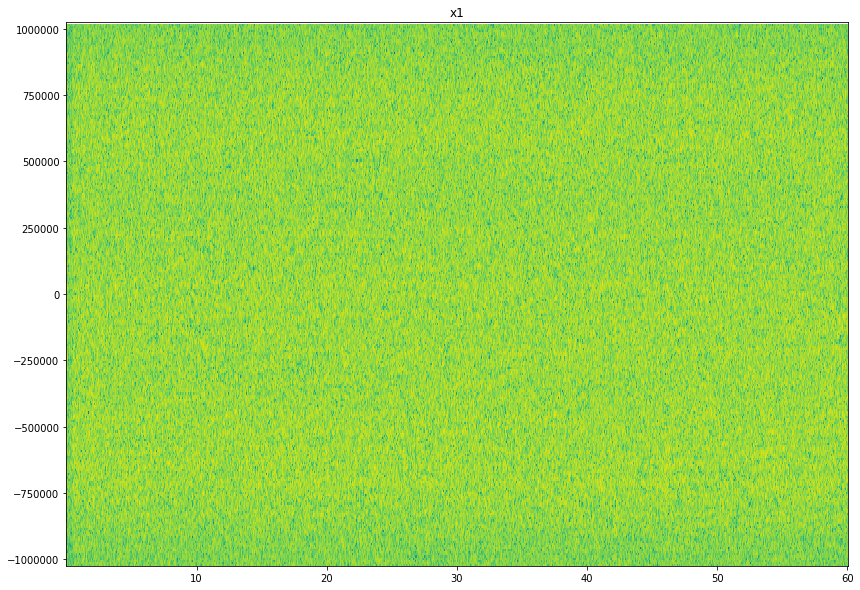

In [87]:
plt.figure(figsize=(14,10))
plt.specgram(x1, NFFT=256, Fs=Fs)  
plt.title("x1")  
plt.ylim(-Fs/2, Fs/2)  
plt.show()

In [88]:
# To mix the data down, generate a digital complex exponential 
# (with the same length as x1) with phase -F_offset/Fs
fc1 = np.exp(-1.0j*2.0*np.pi* F_offset/Fs*np.arange(len(x1)))  
# Now, just multiply x1 and the digital complex expontential
x2 = x1 * fc1  

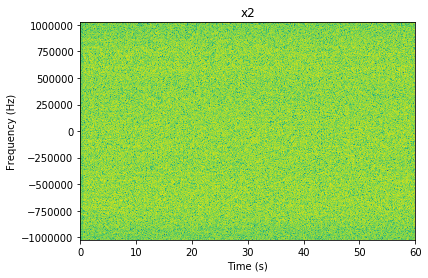

In [89]:
plt.specgram(x2, NFFT=2048, Fs=Fs)  
plt.title("x2")  
plt.xlabel("Time (s)")  
plt.ylabel("Frequency (Hz)")  
plt.ylim(-Fs/2, Fs/2)  
plt.xlim(0,len(x2)/Fs)  
plt.ticklabel_format(style='plain', axis='y' )  
plt.show()

In [90]:
# An FM broadcast signal has  a bandwidth of 200 kHz
f_bw = 40000  
dec_rate = int(Fs / f_bw)  
x4 = signal.decimate(x2, dec_rate)  
# Calculate the new sampling rate
Fs_y = Fs/dec_rate  

/home/biel/miniconda3/envs/apt/lib/python3.7/site-packages/scipy/signal/filter_design.py:1622: BadCoefficients: Badly conditioned filter coefficients (numerator): the results may be meaningless
  "results may be meaningless", BadCoefficients)


In [93]:
Fs_y

40156.86274509804

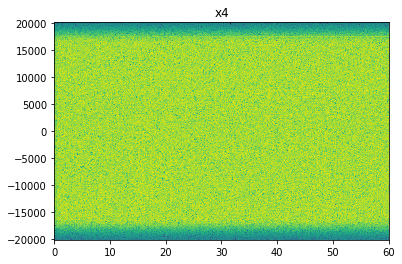

In [94]:
plt.specgram(x4, NFFT=2048, Fs=Fs_y)  
plt.title("x4")  
plt.ylim(-Fs_y/2, Fs_y/2)  
plt.xlim(0,len(x4)/Fs_y)  
plt.ticklabel_format(style='plain', axis='y' )  
plt.show()

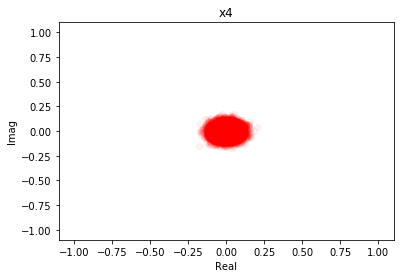

In [95]:
# Plot the constellation of x4.  What does it look like?
plt.scatter(np.real(x4[0:50000]), np.imag(x4[0:50000]), color="red", alpha=0.05)  
plt.title("x4")  
plt.xlabel("Real")  
plt.xlim(-1.1,1.1)  
plt.ylabel("Imag")  
plt.ylim(-1.1,1.1)  
plt.show()

In [96]:
### Polar discriminator
y5 = x4[1:] * np.conj(x4[:-1])  
x5 = np.angle(y5)  

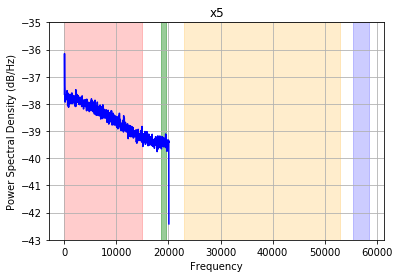

In [97]:
# Note: x5 is now an array of real, not complex, values
# As a result, the PSDs will now be plotted single-sided by default (since
# a real signal has a symmetric spectrum)
# Plot the PSD of x5
plt.psd(x5, NFFT=2048, Fs=Fs_y, color="blue")  
plt.title("x5")  
plt.axvspan(0, 15000, color="red", alpha=0.2)  
plt.axvspan(19000-500, 19000+500, color="green", alpha=0.4)  
plt.axvspan(19000*2-15000, 19000*2+15000, color="orange", alpha=0.2)  
plt.axvspan(19000*3-1500, 19000*3+1500, color="blue", alpha=0.2)  
plt.ticklabel_format(style='plain', axis='y' )  
plt.show()  


In [98]:
# The de-emphasis filter
# Given a signal 'x5' (in a numpy array) with sampling rate Fs_y
d = Fs_y * 75e-6   # Calculate the # of samples to hit the -3dB point  
x = np.exp(-1/d)   # Calculate the decay between each sample  
b = [1-x]          # Create the filter coefficients  
a = [1,-x]  
x6 = signal.lfilter(b,a,x5)  

In [99]:
# Find a decimation rate to achieve audio sampling rate between 44-48 kHz
audio_freq = 44100.0  
dec_audio = int(Fs_y/audio_freq)  
Fs_audio = Fs_y / dec_audio

x7 = signal.decimate(x6, dec_audio)  

ZeroDivisionError: float division by zero

In [102]:
audio_freq

44100.0

In [100]:
# Scale audio to adjust volume
x7 *= 10000 / np.max(np.abs(x7))  
# Save to file as 16-bit signed single-channel audio samples
x7.astype("int16").tofile("wbfm-mono.raw")

NameError: name 'x7' is not defined

In [50]:
print(Fs_audio) 

45600.0


In [51]:
from scipy.io import wavfile

In [52]:
wavfile.write('out.wav', int(Fs_audio), x7.astype("int16"))